Ссылка на задание: http://network-science.ddns.net/web/challenges/challenge-page/56/overview


#Challenge Overview

Your goal is to generate a network that is as close as possible to the original real network. You do not have the original network in the explicit view, but you know some of its statistics. All statistics are in stats.txt file that contains a dictionary of the form
- number_nodes (number of nodes): value
- number_cc (number of connected components): value, sigma
- radius (radius of giant component): value, sigma
- diameter (diameter of giant component): value, sigma
- average_clustering (average clustering coefficient): value, sigma
- average_path_length (average path length): value, sigma
- degree_cdf (empirical CDF of degree distribution): values, probabilities

Meaning of all these sigmas is described in Evaluation section. 

You can use this code to draw CDF
```py
q_seq, p_seq = stats['degree_cdf']
    plt.plot(
        np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
        np.repeat(p_seq, 2)
    )
    plt.show()
```

In [8]:
from google.colab import drive
drive.mount("/content/gdrive")

import itertools as it
import numpy as np
import pandas as pd
import json
import networkx as nx
import random
import scipy.interpolate as interpolate


fpath_stat = "/content/gdrive/MyDrive/MADE/GraphMLComp01/stats.txt"
fpath_out = "/content/gdrive/MyDrive/MADE/GraphMLComp01/out.txt"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
with open(fpath_stat) as fp:  
  stat = json.load(fp)

stat

{'average_clustering': [0.005066798238955518, 0.001],
 'average_path_length': [11.748410823170731, 2],
 'degree_cdf': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   19,
   21,
   24,
   46],
  [0.0,
   0.6902231668437833,
   0.8517534537725824,
   0.9086078639744952,
   0.9378320935175345,
   0.9516471838469713,
   0.9654622741764081,
   0.9723698193411264,
   0.9776833156216791,
   0.9808714133900106,
   0.9845908607863975,
   0.9888416578108395,
   0.9893730074388948,
   0.9925611052072264,
   0.9936238044633369,
   0.9952178533475027,
   0.9957492029755579,
   0.9968119022316685,
   0.997874601487779,
   0.9989373007438895,
   0.9994686503719448,
   1.0]],
 'diameter': [28, 4],
 'number_cc': [168, 32],
 'number_nodes': 1882,
 'radius': [15, 2]}

In [56]:
bins_deg = [
  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
  10, 11, 12, 13, 14, 15, 16, 17, 19, 21,
  24, 46
]

cdf_deg = [
  0.0, 
  0.6902231668437833, 0.8517534537725824, 0.9086078639744952,
  0.9378320935175345, 0.9516471838469713, 0.9654622741764081,
  0.9723698193411264, 0.9776833156216791, 0.9808714133900106,
  0.9845908607863975, 0.9888416578108395, 0.9893730074388948,
  0.9925611052072264, 0.9936238044633369, 0.9952178533475027,
  0.9957492029755579, 0.9968119022316685, 0.997874601487779,
  0.9989373007438895, 0.9994686503719448,
  1.0
]

dct = dict(zip(bins_deg,cdf_deg))


def inverse_transform_sampling(n_samples):
    inv_cdf = interpolate.interp1d(cdf_deg, bins_deg, kind="next")
    r = np.random.rand(n_samples)
    result = inv_cdf(r).astype(int)
    while result.sum() % 2 != 0:
      idx = random.randint(0, n_samples-1)
      x = random.random()
      result[idx] = int(inv_cdf(x))
    return result

def gauss_dist(x, x_hat):
  return np.exp(-(x[0]-x_hat)**2/(2*x[1]**2))


In [72]:
graph_best = None
k_best = None

for _ in range(100): 
  seq = inverse_transform_sampling(1882)

  g = nx.Graph(nx.configuration_model(seq))
  cc = list(nx.connected_components(g))
  n_cc = len(cc)
  giant = g.subgraph(max(cc, key=len))
  
  avg_cl = gauss_dist(
      stat["average_clustering"],
      nx.average_clustering(g)
  )
  avg_path = gauss_dist(
      stat["average_path_length"],
      nx.average_shortest_path_length(giant)
  )
  diam = gauss_dist(
      stat["diameter"],
      nx.diameter(giant)
  )
  k_cc = gauss_dist(
      stat["number_cc"],
      n_cc
  )
  k_rad = gauss_dist(
      stat["radius"],
      nx.radius(giant)
  )
  k = avg_cl/6+avg_path/6+diam/6+k_cc/6+k_rad/6+.95/6
  if k_best is None or k_best < k:
    k_best = k
    graph_best = g 
  
print("ok")

ok


In [73]:
k_best
# 7053.054457842296


280189833.64598244

In [74]:
# def seq(_):
#   return random.choices(deg, cum_weights=cdf_deg)
# [seq(_) for _ in range(1882)]
with open(fpath_out, "w") as fp:
  for u, v in g.edges():
    fp.write(f"{u} {v}\n")

print("ok")

ok


In [2]:
# плохо resul=0
# pdf = np.diff(cdf_deg)
# deg = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,21,24,46]
# s = random.choices(deg, cum_weights=cdf_deg,k=1882)
# graph = nx.generators.degree_seq.expected_degree_graph(s)
# nx.draw(graph)

# def snobbish_network(n, p, q):
#     # YOUR CODE HERE
#     # raise NotImplementedError()
#     graph = nx.Graph()
#     nodes = list(range(2*n))
#     for node in nodes[:n]:
#         graph.add_node(node, color="blue")
#     for node in nodes[n:]:
#         graph.add_node(node, color="red")
#     colors = nx.get_node_attributes(graph, "color")
#     for u, v in it.combinations(nodes, 2):
#         if colors[u] == colors[v] and random.random() < p:
#             graph.add_edge(u, v)
#         elif colors[u] != colors[v] and random.random() < q:
#             graph.add_edge(u, v)
#     return graph

# graph = snobbish_network(1882, 0.1, 0.01)
graph = nx.erdos_renyi_graph(1882, 1/1882, )

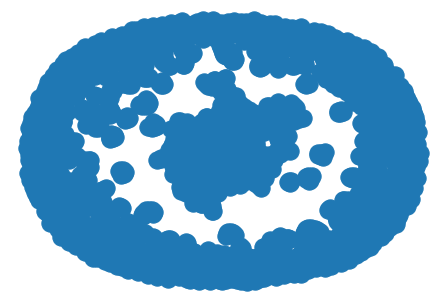

In [36]:
random.random?